# CE-40717: Machine Learning

## HW4-MultiLayer Perceptron (MLP)

The following lines of code will load the [MNIST](http://yann.lecun.com/exdb/mnist/) data and turn them
into numpy arrays, you can print their shape if you like.
You can also transform the data as you wish, including seperating
the training data for cross validation.

If you have the data (on google drive or locally) change the root
address accordingly, if you don't, set download=True but you might encounter
some problems downloading the data.

In [1]:
"""
    Afshin Karimi
    Std Number: 99210431
"""
import torchvision.datasets as ds
import numpy as np
import pandas as pd

data_train = np.array(ds.MNIST(root="./data", train=True, download=True).data)
target_train = np.array(ds.MNIST(root="./data", train=True, download=True).targets)
data_test = np.array(ds.MNIST(root="./data", train=False, download=True).data)
target_test = np.array(ds.MNIST(root="./data", train=False, download=True).targets)

#### Transform the data! ####
data_train = data_train/255
data_train = data_train.reshape(data_train.shape[0],data_train.shape[1]*data_train.shape[2])
data_test = data_test/255
data_test = data_test.reshape(data_test.shape[0],data_test.shape[1]*data_test.shape[2])

### Part1:
Complete the functions of the MLP class to create
a MultiLayer Perceptron

In [2]:
def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A
    

def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size


def cross_entropy(predictions, targets, epsilon=1e-12):
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(targets*np.log(predictions+1e-9))/N
    return ce

In [ ]:
class MLP:
    def __init__(self, in_dimensions, hidden_dimensions, out_dimensions):
        self.w1 = np.random.rand(hidden_dimensions, in_dimensions) - 0.5
        self.b1 = np.random.rand(hidden_dimensions, 1) - 0.5
        self.w2 = np.random.rand(out_dimensions, hidden_dimensions) - 0.5
        self.b2 = np.random.rand(out_dimensions, 1) - 0.5

    def forward(self, x):
        # perform a forward pass of the network and return the result
        # remember to retain the value of each node (i.e. self.h1_forward)
        # in order to use in backpropagation
        # Use whatever activation function you wish for the first layer
        # and softmax activation for the output layer

        # input layer
        self.A0_forward = x.T

        # input layer to hidden layer 
        self.z1_forward = (self.w1 @ self.A0_forward) + self.b1
        self.A1_forward = ReLU(self.z1_forward)

        # hidden layer to output layer
        self.z2_forward = (self.w2 @ self.A1_forward) + self.b2
        self.A2_forward = softmax(self.z2_forward)


    def backward(self, loss, y):
        # perform backpropagation on the loss value and compute the gradient 
        # w.r.t. every element of the network and retain them (i.e. self.w1_backward)

        one_hot_Y = one_hot(y)
        self.z2_backward = self.A2_forward - one_hot_Y
        self.w2_backward = 1 / y.size * self.z2_backward @ self.A1_forward.T
        self.b2_backward = 1 / y.size * np.sum(self.z2_backward)
        self.z1_backward = (self.w2.T @ self.z2_backward) * ReLU_deriv(self.z1_forward)
        self.w1_backward = 1 / y.size * self.z1_backward @ self.A0_forward.T
        self.b1_backward = 1 / y.size * np.sum(self.z1_backward)

    def step(self, lr, lam):
        # simply update all the weights using the gradinets computed in backward
        # and the given learning rate with SGD
        # don't forget to use regularization

        self.w1 -= (lr * self.w1_backward - (self.w1*lam*lr))
        self.b1 -= (lr * self.b1_backward - (self.b1*lam*lr))
        self.w2 -= (lr * self.w2_backward - (self.w2*lam*lr))
        self.b2 -= (lr * self.b2_backward - (self.b2*lam*lr))

### Part2:
Make instances of your network and train them **using l2 regularization and choose the lambda using k-fold cross validation
(set the candidate lambda as you wish)**.

You may choose the hyperparameters (i.e. num of epochs, learning rate etc.)
as you wish. 

Then train a final model on all the training data with the chosen lambda.


In [ ]:
n_epochs = 200 # number of epochs
lr = 0.25 # learning rate
k = 5 # number of folds
in_dim = 28 * 28 # MNIST has 28*28 images
hidden_dim = 32 # number of hidden dimensions for the hidden layer
out_dim =  10 # MNIST has 10 classes
fold_len = int(data_train.shape[0]/k)
lambdas = [0.0001,0.001, 0.01] 
best_lambda = lambdas[-1]
best_acc = 0

for l in lambdas:
    
    acc = 0 # accuracy for current lambda
    loss = 0 # loss for current lambda
    acc_list=[]
    loss_list=[]
    for j in range(k):
        model = MLP(in_dim, hidden_dim, out_dim)
        fold_train_set = np.concatenate((data_train[:j * fold_len],data_train[ (j + 1) * fold_len:])) # the training data for the current fold
        fold_train_target = np.concatenate((target_train[:j * fold_len],target_train[ (j + 1) * fold_len:])) # the training targets for the current fold
        val_set = data_train[j * fold_len:(j + 1) * fold_len] # the validation data for the current fold
        val_target = target_train[j * fold_len:(j + 1) * fold_len] # the validation targets for the current fold

        for i in range(n_epochs):
            # train the model on the data with the curent lambda
            model.forward(fold_train_set)
            model.backward(loss,fold_train_target)
            model.step(lr,l)
        # test the model on the current validation data
        model.forward(val_set)
        pred = get_predictions(model.A2_forward)
        fold_acc = get_accuracy(pred, val_target)# current fold accuracy
        acc_list.append(fold_acc)
        fold_loss = cross_entropy(pred, val_target)
        loss_list.append(fold_loss)

    acc = max(acc_list)
    loss= min(loss_list)
    print("Lambda:", l)
    print("Loss: %.4f Accuracy: %.4f" % (loss, acc))
    print()
    if acc > best_acc:
        best_acc = acc
        best_lambda = l

print("Best lambda is",best_lambda, "with %.4f accuracy" % best_acc)

Lambda: 0.0001
Loss: 0.6355 Accuracy: 0.8871

Lambda: 0.001
Loss: 0.7115 Accuracy: 0.8861

Lambda: 0.01
Loss: 0.7546 Accuracy: 0.8664

Best lambda is 0.0001 with 0.8871 accuracy


### Part3:
Train a final model using the best lambda on all the training data

In [ ]:
n_epochs = 200 # number of epochs
lr = 0.25 # learning rate
model = MLP(in_dim, hidden_dim, out_dim)# new model
loss_history = []
acc_history = []
for i in range(n_epochs):
    #### training code here ####
    model.forward(data_train)
    pred = get_predictions(model.A2_forward)
    acc = get_accuracy(pred, target_train)
    acc_history.append(acc)
    loss = cross_entropy(pred, target_train)
    loss_history.append(loss)
    model.backward(loss,target_train)
    model.step(lr, best_lambda)
    if (i % 10 == 0 and i != 0) or i == n_epochs-1:
        print("epoch:", i)
        print("Loss: %.4f Accuracy: %.4f" % (loss, acc))

epoch: 10
Loss: 6.1476 Accuracy: 0.4648
epoch: 20
Loss: 4.0305 Accuracy: 0.6270
epoch: 30
Loss: 2.8994 Accuracy: 0.7061
epoch: 40
Loss: 2.2653 Accuracy: 0.7502
epoch: 50
Loss: 1.9085 Accuracy: 0.7792
epoch: 60
Loss: 1.6799 Accuracy: 0.7913
epoch: 70
Loss: 1.4778 Accuracy: 0.7729
epoch: 80
Loss: 1.3784 Accuracy: 0.8149
epoch: 90
Loss: 1.3076 Accuracy: 0.8305
epoch: 100
Loss: 1.2361 Accuracy: 0.8381
epoch: 110
Loss: 1.1794 Accuracy: 0.8444
epoch: 120
Loss: 1.1173 Accuracy: 0.8490
epoch: 130
Loss: 1.0375 Accuracy: 0.8529
epoch: 140
Loss: 1.0019 Accuracy: 0.8565
epoch: 150
Loss: 0.9736 Accuracy: 0.8601
epoch: 160
Loss: 0.9501 Accuracy: 0.8635
epoch: 170
Loss: 0.9094 Accuracy: 0.8672
epoch: 180
Loss: 0.9011 Accuracy: 0.8700
epoch: 190
Loss: 0.8848 Accuracy: 0.8725
epoch: 199
Loss: 0.8258 Accuracy: 0.8743


### Part4:

Plot the training loss value and accuracy (mean over all batches each epoch if you're using mini-batches) over epochs
for the final model that is trained on all the training data

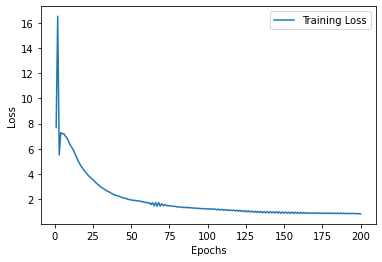

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, n_epochs+1)
plt.plot(epochs, loss_history, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

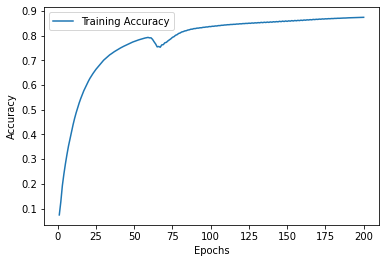

In [ ]:
plt.plot(epochs, acc_history, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Use your network on the test set and report the accuracy, you must get at least 70% accuracy on the test set.

In [ ]:
# compute accuracy on test set
model.forward(data_test)
pred = get_predictions(model.A2_forward)
acc = get_accuracy(pred, target_test)
print(f"Accuracy for test set : {acc*100 :2f} %")

Accuracy for test set : 88.020000 %


In [ ]:
def make_predictions(X):
    model.forward(X)
    predictions = get_predictions(model.A2_forward)
    return predictions

def test_prediction(index):
    current_image = data_test.T[:, index, None]
    # print(current_image.shape)
    prediction = make_predictions(current_image.T)
    label = target_test.reshape(10000,1)[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [7]
Label:  [7]


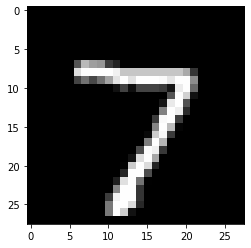

Prediction:  [2]
Label:  [2]


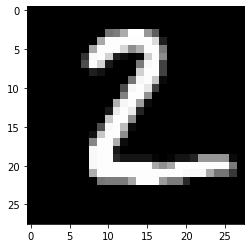

Prediction:  [1]
Label:  [1]


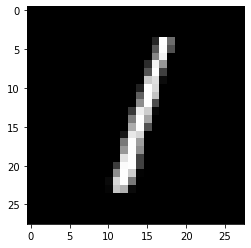

Prediction:  [0]
Label:  [0]


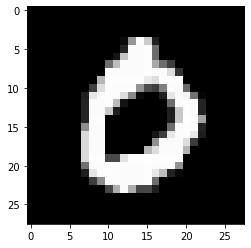

Prediction:  [4]
Label:  [4]


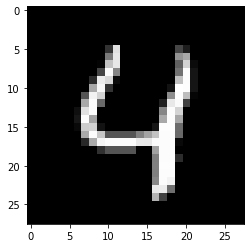

Prediction:  [1]
Label:  [1]


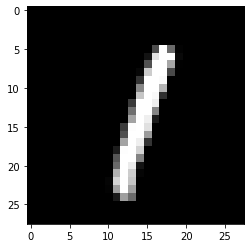

Prediction:  [4]
Label:  [4]


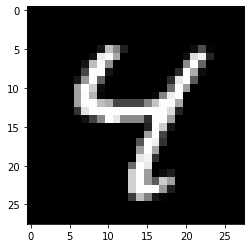

Prediction:  [9]
Label:  [9]


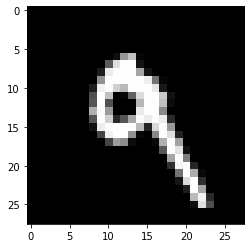

Prediction:  [6]
Label:  [5]


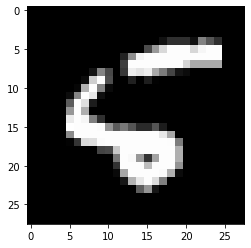

Prediction:  [9]
Label:  [9]


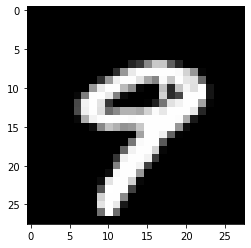

In [ ]:
for i in range(10):
    test_prediction(i)

Below you can add code cells and improve on the network structure as you see fit (it still must be an MLP), train and test your network and explain why it works better.


In [6]:
class Improved_MLP:
    def __init__(self, in_dimensions, hidden_dimensions1, hidden_dimensions2, out_dimensions):
        self.w1 = np.random.rand(hidden_dimensions1, in_dimensions) - 0.5
        self.b1 = np.random.rand(hidden_dimensions1, 1) - 0.5
        self.w2 = np.random.rand(hidden_dimensions2, hidden_dimensions1) - 0.5
        self.b2 = np.random.rand(hidden_dimensions2, 1) - 0.5
        self.w3 = np.random.rand(out_dimensions, hidden_dimensions2) - 0.5
        self.b3 = np.random.rand(out_dimensions, 1) - 0.5
    
    def forward(self, x):
        # perform a forward pass of the network and return the result
        # remember to retain the value of each node (i.e. self.h1_forward)
        # in order to use in backpropagation
        # Use whatever activation function you wish for the first layer
        # and softmax activation for the output layer

        # input layer
        self.A0_forward = x.T

        # input layer to hidden layer1 
        self.z1_forward = (self.w1 @ self.A0_forward) + self.b1
        self.A1_forward = ReLU(self.z1_forward)

        # hidden layer1  to hidden layer2 
        self.z2_forward = (self.w2 @ self.A1_forward) + self.b2
        self.A2_forward = ReLU(self.z2_forward)

        # hidden layer to output layer
        self.z3_forward = (self.w3 @ self.A2_forward) + self.b3
        self.A3_forward = softmax(self.z3_forward)


    def backward(self, loss, y):
        # perform backpropagation on the loss value and compute the gradient 
        # w.r.t. every element of the network and retain them (i.e. self.w1_backward)
        one_hot_Y = one_hot(y)
        self.z3_backward = self.A3_forward - one_hot_Y
        self.w3_backward = 1 / y.size * self.z3_backward @ self.A2_forward.T
        self.b3_backward = 1 / y.size * np.sum(self.z3_backward)

        self.z2_backward = (self.w3.T @ self.z3_backward) * ReLU_deriv(self.z2_forward)
        self.w2_backward = 1 / y.size * self.z2_backward @ self.A1_forward.T
        self.b2_backward = 1 / y.size * np.sum(self.z2_backward)

        self.z1_backward = (self.w2.T @ self.z2_backward) * ReLU_deriv(self.z1_forward)
        self.w1_backward = 1 / y.size * self.z1_backward @ self.A0_forward.T
        self.b1_backward = 1 / y.size * np.sum(self.z1_backward)


    def step(self, lr, lam):
        # simply update all the weights using the gradinets computed in backward
        # and the given learning rate with SGD
        # don't forget to use regularization
        self.w1 -= (lr * self.w1_backward - (self.w1*lam*lr))
        self.b1 -= (lr * self.b1_backward - (self.b1*lam*lr))
        self.w2 -= (lr * self.w2_backward - (self.w2*lam*lr))
        self.b2 -= (lr * self.b2_backward - (self.b2*lam*lr))
        self.w3 -= (lr * self.w3_backward - (self.w3*lam*lr))
        self.b3 -= (lr * self.b3_backward - (self.b3*lam*lr))

In [9]:
n_epochs = 25 # number of epochs
lr = 0.1 # learning rate
in_dim = 28 * 28 # MNIST has 28*28 images
hidden_dim1 = 128 # number of hidden dimensions for the hidden layer
hidden_dim2 = 32 # number of hidden dimensions for the hidden layer
out_dim =  10 # MNIST has 10 classes
best_lambda = 0.0001
batch_size = 100
batch_count = int(len(data_train) / batch_size)
model = Improved_MLP(in_dim, hidden_dim1, hidden_dim2, out_dim)# new model

for i in range(n_epochs):
    epoch_loss = 0
    epoch_acc = 0
    for batch_number in range(batch_count):
        batch = np.random.choice(len(data_train), batch_size)
        batch_x, batch_y = data_train[batch], target_train[batch]
        model.forward(batch_x)
        pred = get_predictions(model.A3_forward)
        acc = get_accuracy(pred, batch_y)
        loss = cross_entropy(pred, batch_y)
        epoch_loss += loss
        epoch_acc += acc
        model.backward(loss,batch_y)
        model.step(lr, best_lambda)
        
    print("epoch:", i+1)
    print("Loss: %.4f Accuracy: %.4f" % (epoch_loss / batch_count, epoch_acc / batch_count))

epoch: 1
Loss: 1.2085 Accuracy: 0.8315
epoch: 2
Loss: 0.4991 Accuracy: 0.9200
epoch: 3
Loss: 0.4379 Accuracy: 0.9354
epoch: 4
Loss: 0.3360 Accuracy: 0.9453
epoch: 5
Loss: 0.3575 Accuracy: 0.9513
epoch: 6
Loss: 0.3077 Accuracy: 0.9547
epoch: 7
Loss: 0.3150 Accuracy: 0.9590
epoch: 8
Loss: 0.1855 Accuracy: 0.9630
epoch: 9
Loss: 0.2279 Accuracy: 0.9665
epoch: 10
Loss: 0.1986 Accuracy: 0.9672
epoch: 11
Loss: 0.1886 Accuracy: 0.9709
epoch: 12
Loss: 0.1830 Accuracy: 0.9728
epoch: 13
Loss: 0.1699 Accuracy: 0.9741
epoch: 14
Loss: 0.1658 Accuracy: 0.9753
epoch: 15
Loss: 0.1343 Accuracy: 0.9777
epoch: 16
Loss: 0.1036 Accuracy: 0.9790
epoch: 17
Loss: 0.1451 Accuracy: 0.9795
epoch: 18
Loss: 0.1178 Accuracy: 0.9817
epoch: 19
Loss: 0.1088 Accuracy: 0.9816
epoch: 20
Loss: 0.1278 Accuracy: 0.9836
epoch: 21
Loss: 0.0936 Accuracy: 0.9846
epoch: 22
Loss: 0.0784 Accuracy: 0.9857
epoch: 23
Loss: 0.0781 Accuracy: 0.9859
epoch: 24
Loss: 0.0819 Accuracy: 0.9870
epoch: 25
Loss: 0.0736 Accuracy: 0.9887


In [10]:
# compute accuracy on test set
model.forward(data_test)
pred = get_predictions(model.A3_forward)
acc = get_accuracy(pred, target_test)
print(f"Accuracy for test set : {acc*100 :2f} %")

Accuracy for test set : 96.500000 %


### I've used deeper network with 2 hidden layer for this network. dimensions of first hidden layer is 128 and dimensions for second hidden layer is 32. Also I used mini batch gradient descent to improve network optimization